In [30]:
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem
import pandas as pd
import numpy as np
from ema_workbench import (Model, RealParameter, IntegerParameter, CategoricalParameter,
                           ScalarOutcome, perform_experiments, Samplers, Policy, Scenario)
from ema_workbench.em_framework import (SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (EpsNSGAII, Convergence)
from ema_workbench.em_framework.optimization import (ArchiveLogger,Problem, EpsilonProgress)
from ema_workbench.analysis import parcoords
from dike_model_function import DikeNetwork

def sum_over(*args):
    numbers = []
    for entry in args:
        try:
            value = sum(entry)
        except TypeError:
            value = entry
        numbers.append(value)
    return sum(numbers)

def get_model_for_problem_formulation(problem_formulation_id):
    function = DikeNetwork()
    dike_model = Model("dikesnet", function=function)

    Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
    cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}
    cat_uncert = {f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in function.planning_steps}
    Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

    uncertainties = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]))

    dike_height_levers = []
    for dike in function.dikelist:
        for uncert_name in Real_uncert.keys():
            name = f"{dike}_{uncert_name}"
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = f"{dike}_{uncert_name}"
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))

        for n in function.planning_steps:
            name = f"{dike}_DikeIncrease {n}"
            dike_height_levers.append(IntegerParameter(name, 0, 10))

    dike_model.uncertainties = uncertainties

    dike_height_levers.append(IntegerParameter("EWS_DaysToThreat", 0, 4))  # days
    # Set levers: No RfR, dike heightening
    dike_model.levers = dike_height_levers

    # Define the outcomes
    outcomes = [
        ScalarOutcome('Total Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist] +
                      [f"{dike}_Dike Investment Costs" for dike in function.dikelist] +
                      ["RfR Total Costs"]
        ),
        ScalarOutcome('Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Number of Deaths" for dike in function.dikelist]
        ),
        ScalarOutcome('Expected Annual Damage', kind=ScalarOutcome.MINIMIZE, function=sum_over, variable_name=[
            f"{dike}_Expected Annual Damage" for dike in function.dikelist]),
        ScalarOutcome('Dike Investment Costs', kind=ScalarOutcome.MINIMIZE, function=sum_over,
                      variable_name=[f"{dike}_Dike Investment Costs" for dike in function.dikelist])
    ]

    dike_model.outcomes = outcomes

    return dike_model
# Get the model for a specific problem formulation
problem_formulation_id = 6  # Change this to the desired problem formulation
dike_model = get_model_for_problem_formulation(problem_formulation_id)


In [40]:
import pandas as pd
import seaborn as sns
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, epsilon_nondominated, ArchiveLogger
import matplotlib.pyplot as plt

# Load the archive
archives = ArchiveLogger.load_archives('archives/single_run.tar.gz')

# Prepare the data
for key in archives:
    archives[key] = archives[key].drop('Unnamed: 0', axis=1)

# Extract dataframes from the archive
archive_dfs = list(archives.values())

# Create the problem
problem = to_problem(dike_model, searchover="levers")

# Calculate the reference set
reference_set = epsilon_nondominated(archive_dfs, [0.05] * len(dike_model.outcomes), problem)

# Initialize metrics
hv = HypervolumeMetric(reference_set, problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)

# Calculate metrics
metrics = []
for nfe, archive in archives.items():
    scores = {
        "generational_distance": gd.calculate(archive),
        "hypervolume": hv.calculate(archive),
        "epsilon_indicator": ei.calculate(archive),
        "inverted_gd": ig.calculate(archive),
        "spacing": sm.calculate(archive),
        "nfe": int(nfe),
    }
    metrics.append(scores)
metrics = pd.DataFrame.from_dict(metrics)

# Sort metrics by number of function evaluations
metrics.sort_values(by="nfe", inplace=True)

# Plot metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(14, 16), sharex=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes

ax1.plot(metrics.nfe, metrics.hypervolume)
ax1.set_ylabel("hypervolume")

# Assuming convergence is a DataFrame with 'nfe' and 'epsilon_progress' columns
ax2.plot(metrics.nfe, metrics['epsilon_progress'] if 'epsilon_progress' in metrics.columns else [0] * len(metrics.nfe))
ax2.set_ylabel("$\epsilon$ progress")

ax3.plot(metrics.nfe, metrics.generational_distance)
ax3.set_ylabel("generational distance")

ax4.plot(metrics.nfe, metrics.epsilon_indicator)
ax4.set_ylabel("epsilon indicator")

ax5.plot(metrics.nfe, metrics.inverted_gd)
ax5.set_ylabel("inverted generational\ndistance")

ax6.plot(metrics.nfe, metrics.spacing)
ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")

sns.despine(fig)
plt.show()


C:\Users\Joost\PycharmProjects\venv\lib\site-packages\ema_workbench\em_framework\optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


EMAError: Parameter names ['A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'] not found in archive

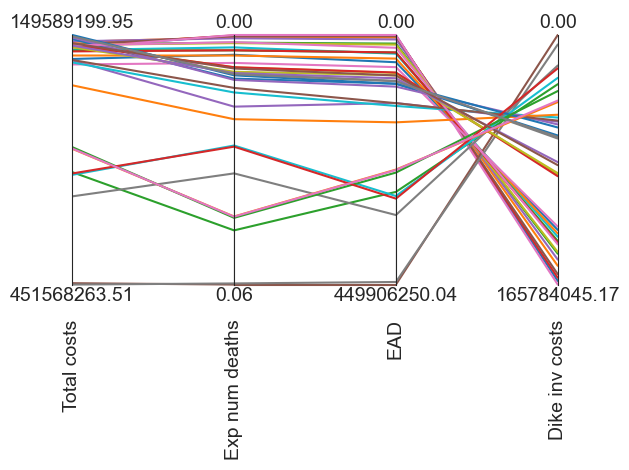

In [16]:
import pandas as pd
import seaborn as sns
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

# Load the optimization results
result_df = pd.read_csv('optimization_outcomes_singlerun.csv')

# Define the columns to plot
columns_to_plot = ['Total Costs', 'Expected Number of Deaths', 'Expected Annual Damage', 'Dike Investment Costs']
custom_column_names = ['Total costs', 'Exp num deaths', 'EAD', 'Dike inv costs']

# Ensure the columns are present in the results
present_columns = [col for col in columns_to_plot if col in result_df.columns]

# Rename the outcomes columns for better readability
outcomes = result_df[present_columns]
outcomes.columns = custom_column_names

# Define limits for parallel coordinates plot
limits = parcoords.get_limits(outcomes)

# Create parallel axes
axes = parcoords.ParallelAxes(limits)

# Plot the outcomes
axes.plot(outcomes)

# Invert the axis for outcomes where lower values are better
for col in custom_column_names:
    axes.invert_axis(col)

# Display the plot
plt.show()
